<a href="https://colab.research.google.com/github/AArna1211/Traffic-prediction/blob/main/TP_VMD%2BACM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [76]:
!pip install vmdpy

In [77]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_absolute_error
from vmdpy import VMD
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [78]:
data = pd.read_csv("/content/Traffic.csv")

In [79]:
# Encode categorical "Traffic Situation"
label_encoder = LabelEncoder()
data["Traffic Situation Encoded"] = label_encoder.fit_transform(data["Traffic Situation"])

# Prepare features and labels
X = data[["CarCount", "BikeCount", "BusCount", "TruckCount", "Total"]].values
y = data["Traffic Situation Encoded"].values

In [80]:
# Apply Variational Mode Decomposition (VMD)
alpha = 2000      # moderate bandwidth constraint
tau = 0.          # noise-tolerance (no strict fidelity enforcement)
K = 3             # number of modes
DC = 0            # no DC part imposed
init = 1          # initialize modes randomly
tol = 1e-6        # tolerance


In [81]:
u, u_hat, omega = VMD(X[:, -1], alpha, tau, K, DC, init, tol)  # Decomposing only "Total" column
X_vmd = np.column_stack([u[i] for i in range(K)])


In [82]:
# Compute Auto-correlation mechanism
corr_matrix = np.corrcoef(X_vmd.T)
corr_scores = np.mean(corr_matrix, axis=1)
selected_modes = np.argsort(corr_scores)[-2:]  # Select two most correlated modes
X_vmd_selected = X_vmd[:, selected_modes]


In [83]:
# Reshape input for time-series forecasting (sequence length = 3 for long-term prediction)
sequence_length = 3
X_sequences = []
y_sequences = []
for i in range(len(X_vmd_selected) - sequence_length):
    X_sequences.append(X_vmd_selected[i:i + sequence_length])
    y_sequences.append(y[i + sequence_length])
X_sequences = np.array(X_sequences)
y_sequences = np.array(y_sequences)

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_sequences, y_sequences, test_size=0.2, random_state=42)

In [84]:
# Define GRU model for long-term forecasting
model = Sequential([
    GRU(64, activation='relu', return_sequences=True, input_shape=(sequence_length, X_vmd_selected.shape[1])),
    GRU(32, activation='relu'),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(len(label_encoder.classes_), activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [85]:
# Implement Early Stopping
#early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

In [91]:
# Train model
history = model.fit(X_train, y_train, epochs=50, batch_size=10, validation_data=(X_test, y_test), verbose=1, )

Epoch 1/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.7247 - loss: 0.6993 - val_accuracy: 0.7395 - val_loss: 0.6507
Epoch 2/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7376 - loss: 0.6555 - val_accuracy: 0.7597 - val_loss: 0.6319
Epoch 3/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7332 - loss: 0.6587 - val_accuracy: 0.7647 - val_loss: 0.6479
Epoch 4/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7331 - loss: 0.6705 - val_accuracy: 0.7378 - val_loss: 0.6332
Epoch 5/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.7217 - loss: 0.6953 - val_accuracy: 0.7496 - val_loss: 0.6490
Epoch 6/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7374 - loss: 0.6509 - val_accuracy: 0.7496 - val_loss: 0.6411
Epoch 7/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7334 - loss: 0.6694 - val_accuracy: 0.7496 - val_loss: 0.6409
Epoch 8/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7138 - loss: 0.6829 - val_accuracy

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Test Accuracy: 0.7513
Mean Absolute Error: 0.4303


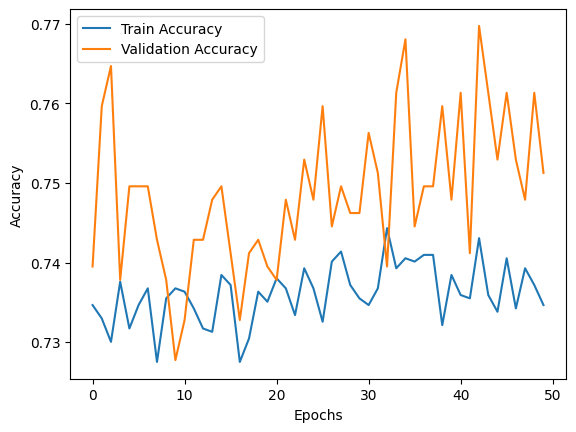

In [92]:
# Evaluate model
y_pred = np.argmax(model.predict(X_test), axis=1)
accuracy = accuracy_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")

# Plot training history
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()